# Handwritten Digit Classification with PyTorch

In this notebook, I will be implementing and comparing different Neural Network architectures to perform handrwritten digit classification on the MNIST dataset.

## Install required packages

In [ ]:
!pip3 install numpy

In [ ]:
!pip3 install torch torchvision

In [ ]:
!pip3 install matplotlib

In [ ]:
!pip3 install torch-summary

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## Download and Prepare the Dataset 📦

In [ ]:
from torchvision import transforms as T

In [ ]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(0.5, 0.5)
    ])

In [ ]:
from torchvision import datasets

trainset = datasets.MNIST("MNIST_data/", download=True, train=True, transform=transform)
testset = datasets.MNIST("MNIST_data/", download=True, train=False, transform=transform)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Print the size of the train and testsets

In [ ]:
print(f"Size of trainset: {len(trainset)}")
print(f"Size of testset:  {len(testset)}")

Size of trainset: 60000
Size of testset:  10000


Print an exemplary image from the dataset

torch.Size([1, 28, 28])


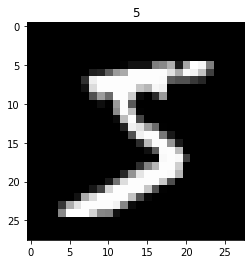

In [ ]:
image, label = trainset[0]
plt.imshow(image.squeeze(),cmap="gray")
plt.title(label);
print(image.shape)

## Create Data Loaders 💾

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
val_share = 0.2
n_train = len(trainset)
split = int(val_share*n_train)

indices = list(range(n_train))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [ ]:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [ ]:
train_loader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
val_loader = DataLoader(trainset, batch_size=64, sampler=val_sampler)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

## Create Neural Networks 🧠

In [ ]:
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

In [ ]:
class vanilla_NN(nn.Module):
    
    def __init__(self):
        super (vanilla_NN,self).__init__()
        
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.25)
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        
        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.ReLU(x)
        
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.ReLU(x)
        
        x = self.fc3(x)
        x = self.dropout(x)
        x = F.log_softmax(x, dim=1)
        
        return x

In [ ]:
summary(vanilla_NN(), input_size=(1,28,28));

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            200,960
├─Linear: 1-2                            32,896
├─Linear: 1-3                            1,290
├─Dropout: 1-4                           --
├─ReLU: 1-5                              --
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0


In [ ]:
class conv_NN(nn.Module):
    
    def __init__(self):
        super(conv_NN,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.batchnorm1 = nn.BatchNorm2d(num_features=8)
        self.batchnorm2 = nn.BatchNorm2d(num_features=16)
        self.ReLU = nn.ReLU()
        self.fc = nn.Linear(16*7*7, 10)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.batchnorm1(x)
        x = self.ReLU(x)
        
        x = self.conv2(x)
        x = self.pool(x)
        x = self.batchnorm2(x)
        x = self.ReLU(x)
        
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        
        return x
        

In [ ]:
summary(conv_NN(), input_size=(1,28,28));

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            80
├─Conv2d: 1-2                            1,168
├─MaxPool2d: 1-3                         --
├─BatchNorm2d: 1-4                       16
├─BatchNorm2d: 1-5                       32
├─ReLU: 1-6                              --
├─Linear: 1-7                            7,850
Total params: 9,146
Trainable params: 9,146
Non-trainable params: 0


## Train Models 📉

In [ ]:
from torch import optim

In [ ]:
def multiclass_accuracy(y_pred, y_true):
    top_p, top_class = y_pred.topk(1, dim=1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
  criterion = nn.NLLLoss()

In [ ]:
def train_model(model, epochs=10):
  optimizer = optim.Adam(model.parameters(), lr=3e-3)
  
  for i in range(epochs):
      train_loss = 0.0
      val_loss = 0.0
      val_acc = 0.0
      
      model.train()
      
      for images, labels in train_loader:
          log_probs = model(images)
          optimizer.zero_grad()
          loss = criterion(log_probs, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
      
      
      model.eval()
      
      for images, labels in val_loader:
          log_probs = model(images)
          probs = torch.exp(log_probs)
          loss = criterion(log_probs, labels)
          val_loss += loss.item()
          val_acc += multiclass_accuracy(probs, labels)
      
      train_loss = train_loss/len(train_loader)
      val_loss = val_loss/len(val_loader)
      val_acc = val_acc/len(val_loader)
      
      print(f"Epoch {i+1}/{epochs}: training loss: {train_loss:.2f}, validation loss: {val_loss:.2f}, validation accuracy: {val_acc*100:.2f}%")
  return model

In [ ]:
trained_conv_NN = train_model(conv_NN())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/10: training loss: 0.13, validation loss: 0.06, validation accuracy: 98.17%
Epoch 2/10: training loss: 0.05, validation loss: 0.06, validation accuracy: 98.25%
Epoch 3/10: training loss: 0.04, validation loss: 0.06, validation accuracy: 98.38%
Epoch 4/10: training loss: 0.03, validation loss: 0.05, validation accuracy: 98.47%
Epoch 5/10: training loss: 0.03, validation loss: 0.05, validation accuracy: 98.52%
Epoch 6/10: training loss: 0.02, validation loss: 0.07, validation accuracy: 98.15%
Epoch 7/10: training loss: 0.02, validation loss: 0.05, validation accuracy: 98.62%
Epoch 8/10: training loss: 0.02, validation loss: 0.06, validation accuracy: 98.55%
Epoch 9/10: training loss: 0.02, validation loss: 0.05, validation accuracy: 98.57%
Epoch 10/10: training loss: 0.02, validation loss: 0.07, validation accuracy: 98.03%


In [ ]:
trained_vanilla_NN = train_model(vanilla_NN())

Epoch 1/10: training loss: 0.81, validation loss: 0.28, validation accuracy: 92.14%
Epoch 2/10: training loss: 0.63, validation loss: 0.26, validation accuracy: 92.46%
Epoch 3/10: training loss: 0.59, validation loss: 0.20, validation accuracy: 94.69%
Epoch 4/10: training loss: 0.57, validation loss: 0.19, validation accuracy: 94.46%
Epoch 5/10: training loss: 0.56, validation loss: 0.18, validation accuracy: 94.92%
Epoch 6/10: training loss: 0.55, validation loss: 0.17, validation accuracy: 95.28%
Epoch 7/10: training loss: 0.54, validation loss: 0.20, validation accuracy: 94.56%
Epoch 8/10: training loss: 0.53, validation loss: 0.18, validation accuracy: 95.14%
Epoch 9/10: training loss: 0.53, validation loss: 0.17, validation accuracy: 95.53%
Epoch 10/10: training loss: 0.53, validation loss: 0.17, validation accuracy: 95.43%


## Final Evaluation ✅

In [ ]:
def evaluate_model(model):
  model.eval()

  test_loss = 0.0
  test_acc = 0.0

  for images, labels in test_loader:
      log_probs = model(images)
      probs = torch.exp(log_probs)
      loss = criterion(log_probs, labels)
      test_loss += loss.item()
      test_acc += multiclass_accuracy(probs, labels)

  test_loss = test_loss/len(test_loader)
  test_acc = test_acc/len(test_loader)

  print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc*100:.2f}%\n")

In [ ]:
print("Final Evaluation - Fully Connected Neural Network:")
evaluate_model(trained_vanilla_NN)

print("Final Evaluation - Convolutional Neural Network:")
evaluate_model(trained_conv_NN)

Final Evaluation - Fully Connected Neural Network:
test loss: 0.15, test accuracy: 95.60%

Final Evaluation - Convolutional Neural Network:
test loss: 0.06, test accuracy: 98.36%



As can be seen from these results, the Convolutional Neural Network (CNN) outperforms the fully connected (vanilla) Neural Network, despite the significatnly smaller number of parameters (235,146 vs. 9,146, respectively).

In addition, it is noticeable that the small number of the CNN leads to tremendously reduced training time, as it already reaches above 98% accuracy after the first epoch and pretty much stays there all the way through. The Fully Connected Neural Network on the other hand converges to its maximum of around 95% only around the 6th to 7th epoch.

This nicely highlghts the advantages of Convolutional Neural Networks for the analysis of structured 2D-data like, for example, images of handwritten digits.